# The QOSF-mentorship program screening task

Author: Sebastian Mair, 23.02.2023

## Management Summary

I selected the screening task to create a QSVM to classify the Iris dataset (4d feature-vectors, 
                                                                             characterizing three classes of flowers).
I found that a straight forward amplitude encoding of the two largest principal components ($2.\arctan{(PC_1/PC_2)}$) with a $U^\dagger U$ fidelity measurement and a $(10 \times 10)$ kernel yields the most satisfying results. The empirical classification performance of the QSVM, as well as the mathematical structure $|\langle \vec{x}_i | \vec{x}_j \rangle|^2$ are equivalent to a classical polynomial kernel of degree $d = 2$.
Further, I evaluated popular kernels with classical equivalents [1](https://link.springer.com/chapter/10.1007/978-3-030-83098-4_6) (angle-encoding and 
amplitude encoding kernels), and two free-from parameterized quantum kernels (one of which had equally high accuracy as amplitude encoding, but higher circuit depth).
This report is focusses on the classification of Versicolor/Virginica, since the remaining class Setosa is readily seperable from the other two (in trials I achieved $acc \approx 1$). The featurespaces for Versicolor and Virginica have some overlap and the classes generally cannot be perfectly seperated.

The final classifier has some unresolved error, that couldn't be fixed due to a close deadline. However, I tried hard, to present a thorough analysis of QSVMs and it's application on this particular dataset.

Results overview:

| Kernel | Accuracy (Versicolor/Virginica) | Training time | Inference time |
| --- | --- | --- | --- |
| Classical linear kernel (Benchmark) | **0.938** | - | - |
| **Amplitude Encoding** | **0.911** | **0.329 s** | **2.677 s** |
| Repeated Amplitude Encoding | 0.822 | 0.45 s | 3.855 s |
| Angle Encoding | 0.888 | 0.451 s | 3.877 s<span> |
| **One Qubit rotation-chain** | **0.877** | - | - |
| ZZ-FeatureMap with additional RX rotations | 0.6 | - | - |
| Best of my ability quantum kernel | 0.877 | - | - |

## The brief

We decided to select participants based on how they will manage to do some simple “screening
tasks”
These tasks have been designed to:
- find out if you have the skills necessary to succeed in our program.
- be doable with basic QC knowledge - nothing should be too hard for you to quickly learn.
- allow you to learn some interesting concepts of QC.
- give you some choices depending on your interests.
What we mean by skills is not knowledge and expertise in QC. It’s the ability to code, learn new
concepts and to meet deadlines.
What are we looking for in these applications?
- Coding skills – clear, readable, well-structured code
- Communication – well-described results, easy to understand, tidy.
- Reliability – submitted on time, all the points from the task description are met
Research skills – asking good questions and answering them methodically
Also, feel free to be creative – once you finish the basic version of the task, you can expand it.
Bonus questions provide just some ideas on how to expand a given topic.
Choose tasks based on your interests, don’t try to pick the easiest one.
You need to do only 1 task. Feel free to do all of them, it might be a good learning opportunity,
but it won’t affect admissions to the program :)

## Selected task

Generate a Quantum Supported Vector Machine (QSVM) using the iris dataset and try
to propose a kernel from a parametric quantum circuit to classify the three
classes(setosa, versicolor, virginica) using the one-vs-all format, the kernel only works
as binary classification. Identify the proposal with the lowest number of qubits and depth
to obtain higher accuracy. You can use the UU † format or using the Swap-Test.

### Motivations for selecting this task
* I briefly read about kernel-methods before, but never took the time to properly understand it, so this will be a good learning opportunity.
* I found some good resources on the topic. In fact, I found so many materials, that it is a challenge to add something of value to the discussion.

### Stuff learned along the way ...
* https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html covers the brief to a very large extend on the quantum side.
* https://scikit-learn.org/stable/modules/svm.html#svm-classification covers the brief to a very large extend on the classical side.

## The solution

In honor of your time, I put my solution to the front of the document, and follow it up with my deduction. I am explicitly short on words in this section, since I have been verbose in the details section.

Imports ...

In [1]:
import functools

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import pennylane as qml
from pennylane import numpy as np

Data loader ...

In [2]:
def load_filtered_iris_data(classes:list=[0,1,2]):
    """Load the iris data, and filter for provided classes. 
    E.g. if you want to load data for the classes Versicolor and Virginica, you need to pass the list {1,2}.
    """
    assert np.min(classes) >= 0, f"Provided classes list contains illegal value {np.min(classes)}, allowed are only 0,1 and 2."
    assert np.max(classes) < 3, f"Provided classes list contains illegal value {np.max(classes)}, allowed are only 0,1 and 2."
    
    indices = list()
    
    for clss in classes:
        indices += list(range(50*(clss), 50*(clss+1)))
    
    iris = datasets.load_iris()
    X_filtered = iris.data[indices,:]
    y_filtered = iris.target[indices]
    
    return X_filtered, y_filtered

Dataloading and Train/Test split (10/90) ...

In [3]:
from sklearn.model_selection import train_test_split

X, y = load_filtered_iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=43210)

Transformations, I found it useful to make a PCA, this way I could also reduce the number of needed qubits ...

In [4]:
# preparing the transformation
X_all, _ = load_filtered_iris_data()
pca1 = PCA(n_components=2).fit(X_all)

# this second transformation might be unnecessary, but I conducted most of my experiments in this space, ...
X_versicolor_and_virginica, _ = load_filtered_iris_data([1,2]) 
pca2 = PCA(n_components=2).fit(X_versicolor_and_virginica)

The quantum kernel and the SVC for the classification Setosa/not-Setosa ...

In [10]:
# prepare the training data
X_train_setosa = pca1.transform(X_train)
y_train_setosa = -np.ones_like(y_train)
y_train_setosa[y_train == 0] = 1

# prepare the kernel
n_qubits = 1
dev_kernel_setosa = qml.device("default.qubit", wires=n_qubits)
    
projector = np.zeros((2, 2))
projector[0, 0] = 1 # this is needed for the U_dag U scheme

@qml.qnode(dev_kernel_setosa)
def setosa_kernel(x1, x2):
    """The quantum kernel"""
    angle_x1 = np.angle(x1[0]+x1[1]*1.j)
    angle_x2 = np.angle(x2[0]+x2[1]*1.j)
    qml.RY(angle_x1, 0)
    qml.RY(-angle_x2, 0)
    return qml.expval(qml.Hermitian(projector, wires=0))

# create the classifier
svm_setosa = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, setosa_kernel)).fit(X_train_setosa, y_train_setosa)

# eval the classifier ...
res = svm_setosa.predict(pca1.transform(X_test)) - 1

true_positives = np.sum(res == y_test)
true_negatives = np.sum(res[y_test != 0] != 0)

print(f"TP: {true_positives}, TN: {true_negatives}, Acc: {(true_positives + true_negatives)/len(y_test)}")


TP: 45, TN: 85, Acc: 0.9629629629629629


The quantum kernel and the SVC for the classification Versicolor/Virginica ...

In [12]:
# prepare the data
# filter away the setosa records, since the should have been classified already at the second class. step.
X_train_vv_tmp = X_train[y_train != 0] 
X_train_vv = pca2.transform(X_train_vv_tmp)

y_train_vv_tmp = y_train[y_train != 0]
y_train_vv = 2*(y_train_vv_tmp-1)-1

# prepare the kernel
dev_kernel_vv = qml.device("default.qubit", wires=3)

def layer1(x, param):
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.CRX(param[0], [0, 1])
    qml.CRX(param[1], [1, 2])
    qml.CRX(param[2], [2, 0])

@qml.qnode(dev_kernel_vv)
def kernel_vv(x1, x2, params):
    """The quantum kernel"""
    projector = np.zeros((2**3, 2**3))
    projector[0, 0] = 1 # this is needed for the U_dag U scheme
    
    qml.Hadamard(2)

    for param in params:
        layer1(x1, param)

    for param in params[::-1]:
        qml.adjoint(layer1)(x2, param)

    qml.Hadamard(2)

    return qml.expval(qml.Hermitian(projector, wires=range(3)))


# prepare the classifier

# these params where inferred through an optimization scheme, details are further below.
params = np.array([[2.27242576, 2.57781135, 0.21708345], [0.37055342, 0.82430572, 0.73117368]])

part_kernel_vv = functools.partial(kernel_vv, params=params)    
svm_vv = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, part_kernel_vv)).fit(X_train_vv, y_train_vv)

# eval the classifier
y_test_vv = y_test[y_test != 0]
y_test_vv = 2*(y_test_vv - 1.5)
X_test_vv = pca2.transform(X_test[y_test != 0])

res = svm_vv.predict(X_test_vv)

acc = np.sum(res == y_test_vv)/len(y_test_vv)

print(f"Acc: {acc}")

Acc: 0.8666666666666667


In [14]:
def get_iris_prediction(X):
    """Predict the iris class for the given feature vectors.
    
    Args:
        X (np.array): (n times 4) feature vector.
        
    Returns:
        np.array(string): the predicted class for the given datapoints.
    """
    y_res = -np.ones(len(X))
    
    # first transform the data into the space spanned by the Principal components 
    # PC0 and PC1 for the entire iris dataset
    X_transf1 = pca1.transform(X)
    is_setosa = np.array(svm_setosa.predict(X_transf1))
    
    vv_indices = np.where(is_setosa == -1)[0]
    X_transf2 = pca2.transform(X[vv_indices])
    is_vericolor = svm_vv.predict(X_transf2)
    vericolor_indices = vv_indices[is_vericolor == 1]
    virginica_indices = vv_indices[is_vericolor == -1]
    
    y_res[is_setosa == 1] = 0
    y_res[vericolor_indices] = 1
    y_res[virginica_indices] = 2
    
    return y_res

iris_pred = get_iris_prediction(X_test)
print(np.sum(iris_pred == y_test)/len(y_test))

0.4222222222222222


There must be still some error, the individual predictors are much stronger, unfortunately, I am already
close to the deadline...

It follows a detailed description how I got to this point.

## A short bit of theory

We are trying to classify datapoints, however, sometimes they are difficult to seperate in the original feature space, e.g. you cannot fit a plane that seperates the data well. To mitigate this, you can apply a feature-map to transform your data into a higher dimensional space, where data seperates more nicely. Theory says, that if seperability doesn't get better, it shouldn't get any worse either, and often-times it gets much better.

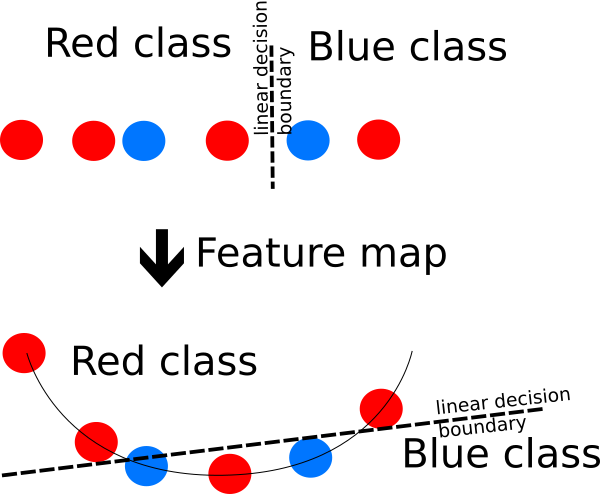

To my knowledge, the choice of a feature map is basically a result of trial and error. 
There are several popular choices for feature maps, you can even use a quantum computer to map your data, 
to calculate functions that are very expensive on a classical computer. But, here comes the caveat, it isn't
possible to directly observe the state of a quantum object. It is only possible to observe the projection of a quantum state onto an Hermitian observable,
e.g. the Pauli-Z operator, so you would have to execute the mapping & measuring many times to approximate the state.

In come kernel methods! The algorithm that creates the decision boundary for us, is the SVM. The SVM maximizes
the distance of data-points of individual classes to the decision boundary, this is described by the so called
hinge loss:

$L = - \sum_{i=0}^m \alpha_i + \frac{1}{2} \sum_{i=0}^m \sum_{j=0}^m \alpha_i \alpha_j f(\vec{x}_i) f(\vec{x}_j) \phi(\vec{x}_i) \cdot \phi(\vec{x}_j)$

Here the $\alpha_i$ values describe the decision hyper-plane, $f(\vec{x}_i)$ the class of the datapoint, and $\phi(\vec{x}_i)$ the feature map.
This loss function does not require the mapped feature vectors directly, but only pair-wise inner products thereof (i.e. a distance
measure between data-points). The expression in the double sum is the so called Gram-matrix.
This we can efficiently calculate on a quantum computer, we only need to measure
the fidelity of two encoded feature vectors, e.g. via SWAP-test or the $U^\dagger U$ formalism.

So the final classification is performed on a feature-space, that is spanned by the pair-wise similarity scores of the vectors selected for constructing the kernel and the to be classified data-point.

Marvelous, let's do it.

## Getting to know the dataset

First, I want to know, what the dataset looks like, to get a feel, for what needs to be done, to get a decent classification result.

I read the Wikipedia article about it: https://en.wikipedia.org/wiki/Iris_flower_data_set

My main take-aways:
* The data comprises 150 records, three classes of flowers, 50 records for each class.
* Each record contains 4 features, to describe a given flower.
* To encode 4 features requires 2 qubits in amplitude encoding (omitting the norm), or 3 qubits in amplitude encoding (maintain norm information).
* The visualizations show that the class "setosa" is easily distinguishable e.g. by pedal length and width, more difficult might be the two other classes "versicolor" and "virginica" https://en.wikipedia.org/wiki/Iris_flower_data_set#/media/File:Iris_dataset_scatterplot.svg
** i.e. I should think of classifying "setosa"/"not-setosa" first, without kernels, and use the quantum kernel methods only on the second classifier "versicolor"/"virginica"

I also found a visualization routine of the dataset in a matplotlib tutorial; convenient as a starter code: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [15]:
# First some basic imports

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np

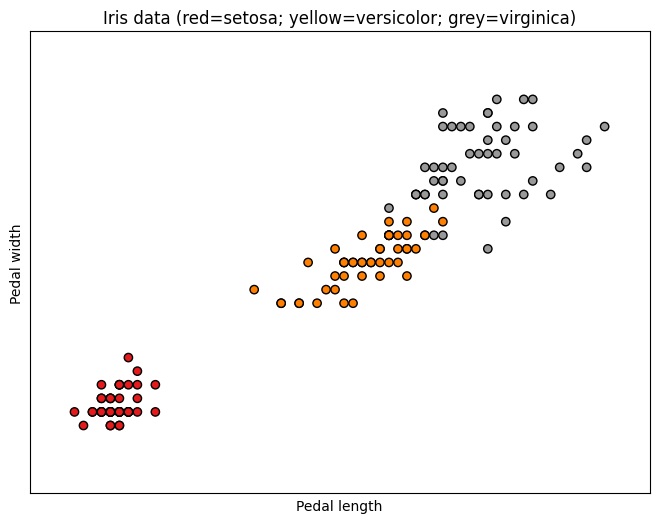

In [16]:
# Iris data to get to know the data
iris = datasets.load_iris()
X = iris.data[:, 2:]  # we only take the last two features, this selection is informed by plots I found on Wikipedia
y = iris.target

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.title("Iris data (red=setosa; yellow=versicolor; grey=virginica)")
plt.xlabel("Pedal length")
plt.ylabel("Pedal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Adapted from a starter code:
``
Code source: Gaël Varoquaux
Modified for documentation by Jaques Grobler
License: BSD 3 clause
``

Next I want to check how the data looks after some basic preprocessing, as this might help me to 
train a stronger classifier, and use up viewer qubits along the way.
The idea to apply a PCA was taken from [this amazing source, by Patrick Huembeli](https://github.com/PatrickHuembeli/QSVM-Introduction/blob/master/Quantum%20Support%20Vector%20Machines.ipynb).

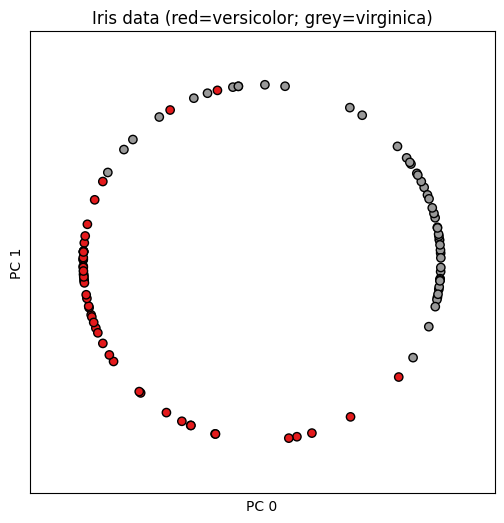

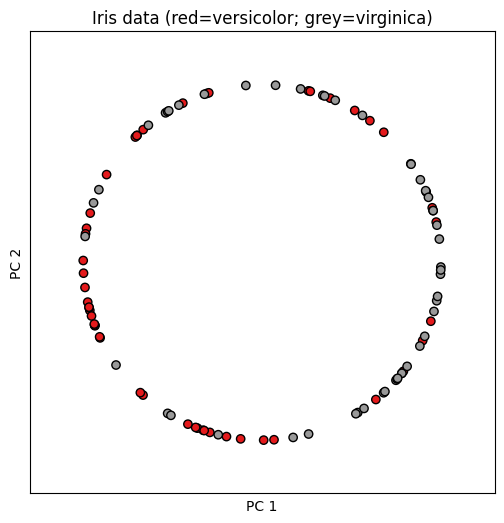

In [18]:
def load_filtered_iris_data(classes:list=[0,1,2]):
    """Load the iris data, and filter for provided classes. 
    E.g. if you want to load data for the classes Versicolor and Virginica, you need to pass the list {1,2}.
    """
    assert np.min(classes) >= 0, f"Provided classes list contains illegal value {np.min(classes)}, allowed are only 0,1 and 2."
    assert np.max(classes) < 3, f"Provided classes list contains illegal value {np.max(classes)}, allowed are only 0,1 and 2."
    
    indices = list()
    
    for clss in classes:
        indices += list(range(50*(clss), 50*(clss+1)))
    
    iris = datasets.load_iris()
    X_filtered = iris.data[indices,:]
    y_filtered = iris.target[indices]
    
    return X_filtered, y_filtered
    

def get_embedding_ready_pcs(X_filtered, pc1:int=0, pc2:int=1, norm:bool=False):
    """
    """
    assert pc1 >= 0 and pc1 < X_filtered.shape[1], f"Requested pc1 {pc1} does not exisit, valid values must be larger than 0 and smaller than the size of a feature vector."
    assert pc2 >= 0 and pc2 < X_filtered.shape[1], f"Requested pc1 {pc2} does not exisit, valid values must be larger than 0 and smaller than the size of a feature vector."
    
    n_components=max(pc1, pc2)+1
    
    pca = PCA(n_components=n_components).fit(X_filtered)
    X_reduced = pca.transform(X_filtered)[:, [pc1, pc2]]
    
    if norm:
        X_norm = np.linalg.norm(X_reduced, axis=1)
        X_norm2 = np.dstack((X_norm, X_norm))

        X_encode = np.squeeze(X_reduced/X_norm2)
    else:
        X_encode = X_reduced
    
    return X_encode, pca

def plot_versicolor_and_virginica_pc(pc1:int=0, pc2:int=1):
    """Plot the pricipal components of the two classes "versicolor" and "virginica" of the Iris dataset.
    
    pc1: 
    """
    assert pc1 >= 0 and pc1 < 4, f"Requested pc1 {pc1} does not exisit, only values 0-3 are allowed."
    assert pc2 >= 0 and pc2 < 4, f"Requested pc2 {pc2} does not exisit, only values 0-3 are allowed."

    X_filtered, y_filtered = load_filtered_iris_data([1,2])
    X_encode, _ = get_embedding_ready_pcs(X_filtered, pc1, pc2, True)
    
    x_min, x_max = -1.3, 1.3 
    y_min, y_max = -1.3, 1.3

    plt.figure(1, figsize=(6, 6))
    plt.clf()

    # Plot the training points
    plt.scatter(X_encode[:, 0], X_encode[:, 1], c=y_filtered, cmap=plt.cm.Set1, edgecolor="k")
    plt.title("Iris data (red=versicolor; grey=virginica)")
    plt.xlabel(f"PC {pc1}")
    plt.ylabel(f"PC {pc2}")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

plot_versicolor_and_virginica_pc()
plot_versicolor_and_virginica_pc(1,2)

Looks like we are going to be alright, seperating these two classes with just the main two principal components, the norm information is not so important.
An interesting extension might be, the classification based on the second and third principal components, as data looks much harder to seperate along these dimensions.

## Loading the data

I decided to go for the most reduced classification possible, and classify the iris-data purely on basis of the two largest principal components.
Long inference times for some of the quantum models informed me to choose relatively small kernel of size $(10 \times 10)$.

In [19]:
X_filtered, y = load_filtered_iris_data([1, 2])
X, _ = get_embedding_ready_pcs(X_filtered, 0, 1, False)
y = 2*(y-1)-1 # relabel the classes [1,2] => [-1,1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=43210)

## Classical benchmarking

It's better to do gain the cheaper insights upfront, plus the classical benchmark will inform me, if I'm in an acceptable range.<br>
Here I created a really basic classical linear SVC routine, that returns the accuracy.

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def classical_SVC(X, y, test_size):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.9) # choose a small training set, to speed up training.

    # create Support Vector Classifier
    svc = SVC(kernel='precomputed')
    kernel_train = np.dot(X_train, X_train.T)  # linear kernel
    svc.fit(kernel_train, y_train)

    # test the classifier performance
    kernel_test = np.dot(X_test, X_train.T)
    y_pred = svc.predict(kernel_test)
    return accuracy_score(y_test, y_pred)

Now, with a very small training set, the predictor's performance can vary a lot, so I do some statistics...

In [21]:
# load the data
X_filtered, y = load_filtered_iris_data([1, 2])
X, _ = get_embedding_ready_pcs(X_filtered, 1,2, False)
y = 2*(y-1)-1 # relabel the classes [1,2] => [-1,1]

accuracy_scores = []
for i in range(10):
    accuracy_scores += [classical_SVC(X, y, 0.9), ]

print("Linear-kernel SVC on the 2nd and 3rd principal comonents w. a 10/90 split.")
print(f"Accuracy: {np.mean(accuracy_scores)} +/- {np.std(accuracy_scores)}")


X, _ = get_embedding_ready_pcs(X_filtered, 0,1, True)

accuracy_scores = []
for i in range(10):
    accuracy_scores += [classical_SVC(X, y, 0.9), ]

print("Linear-kernel SVC on the first two principal comonents w. a 10/90 split.")
print(f"Accuracy: {np.mean(accuracy_scores)} +/- {np.std(accuracy_scores)} \n")

Linear-kernel SVC on the 2nd and 3rd principal comonents w. a 10/90 split.
Accuracy: 0.5211111111111111 +/- 0.06235105709599199
Linear-kernel SVC on the first two principal comonents w. a 10/90 split.
Accuracy: 0.8822222222222222 +/- 0.14691897489836087 



Alright, if we want to be en Par with the classical methods, ... <br>
* If we use the <strong>1st and 2nd principal component</strong>, we must aim for an accuracy of at least <strong>0.90</strong>. <br>
* If we use the <strong>2nd and 3rd principal component</strong> to classify the data, we can aim for a more relaxed accuracy of somewhere around <strong>0.55</strong>.

## Getting to know quantum kernels

As I am new to the topic of QSVMs and kernels, I wanted to implement some standard kernels from the literature [1](https://link.springer.com/chapter/10.1007/978-3-030-83098-4_6), to see how they perform, before going on to more crafty ones... <br>
I also want to learn about the computational effort, therefore, I will be recording the training and inference times.

In [22]:
import time

Starting with the vanilla <strong>amplitude encoding kernel</strong>. From my data analysis, I am convinced, that this
kernel suits my data very well and will perform fine.
The kernel has a classical equivalent of $\kappa(x, x^\prime) = |\mathbf{x^\dagger}\mathbf{x}^\prime|^2$.

In [23]:
def eval_Ampl_Encoding_QSVM(X_train, X_test, y_train, y_test):
    n_qubits = 1
    
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1 # this is needed for the U_dag U scheme

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel"""
        angle_x1 = np.angle(x1[0]+x1[1]*1.j)
        angle_x2 = np.angle(x2[0]+x2[1]*1.j)
        qml.RY(angle_x1, 0)
        qml.RY(-angle_x2, 0)
        return qml.expval(qml.Hermitian(projector, wires=0))

    st = time.time()
    svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel)).fit(X_train, y_train)
    
    ett = time.time()
    y_pred = svm.predict(X_test)

    etp = time.time()
    print(f"Amplitude encoding QSVM Classifier trained in {ett - st} seconds.")
    print(f"Amplitude encoding QSVM Classifier prediction done in  in {etp - ett} seconds.")
    
    return np.sum((y_pred * y_test)==1)/len(y_test)

Continuing with the <strong>angle encoding kernel</strong>, that has the classical equivalent of 
$\kappa(x, x^\prime)=\Pi^N_{k=1}| \cos(x_k - x^\prime_k)|^2$.

In [24]:
def eval_Angle_Encoding_QSVM(X_train, X_test, y_train, y_test):
    n_qubits = len(X_train[0])
    
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1 # this is needed for the U_dag U scheme

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        qml.AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))
    
    st = time.time()
    svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel)).fit(X_train, y_train)
    
    ett = time.time()
    y_pred = svm.predict(X_test)

    etp = time.time()
    print(f"Angle encoding QSVM Classifier trained in {ett - st} seconds.")
    print(f"Angle encoding QSVM Classifier prediction done in  in {etp - ett} seconds.")
    
    return np.sum((y_pred * y_test)==1)/len(y_test)

As the last classically inspired kernel, I checked the <strong>repeated amplitude encoding</strong> kernel. The classical equivalent is $\kappa(\mathbf{x}, \mathbf{x}^\prime) = (|\mathbf{x}^\dagger\mathbf{x}^\prime|^2)^r$. 

In [25]:
def eval_n_Ampl_Encoding_QSVM(X_train, X_test, y_train, y_test, n):
    n_qubits = 1
    
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1 # this is needed for the U_dag U scheme

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel"""
        angle_x1 = np.angle(x1[0]+x1[1]*1.j)
        angle_x2 = np.angle(x2[0]+x2[1]*1.j)
        for i in range(n):
            qml.RY(angle_x1, 0)
        for i in range(n):
            qml.RY(-angle_x2, 0)
        return qml.expval(qml.Hermitian(projector, wires=0))
    
    st = time.time()
    svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel)).fit(X_train, y_train)
    
    ett = time.time()
    y_pred = svm.predict(X_test)

    etp = time.time()
    print(f"n-Amplitude encoding QSVM Classifier trained in {ett - st} seconds.")
    print(f"n-Amplitude encoding QSVM Classifier prediction done in  in {etp - ett} seconds.")
    
    return np.sum((y_pred * y_test)==1)/len(y_test)

Now that all classifiers are in place, I execute them, to compare their performance.

In [26]:
a1 = eval_Ampl_Encoding_QSVM(X_train, X_test, y_train, y_test)
print(f"acc. Ampl. Encoding: {a1}")

a2 = eval_n_Ampl_Encoding_QSVM(X_train, X_test, y_train, y_test, 3)
print(f"acc. n-Ampl. Encoding: {a2}")

a3 = eval_Angle_Encoding_QSVM(X_train, X_test, y_train, y_test)
print(f"acc. Angle Encoding: {a3}")

Amplitude encoding QSVM Classifier trained in 0.3351099491119385 seconds.
Amplitude encoding QSVM Classifier prediction done in  in 2.8204002380371094 seconds.
acc. Ampl. Encoding: 0.9111111111111111
n-Amplitude encoding QSVM Classifier trained in 0.444591760635376 seconds.
n-Amplitude encoding QSVM Classifier prediction done in  in 3.929128646850586 seconds.
acc. n-Ampl. Encoding: 0.8222222222222222
Angle encoding QSVM Classifier trained in 0.430187463760376 seconds.
Angle encoding QSVM Classifier prediction done in  in 3.5839483737945557 seconds.
acc. Angle Encoding: 0.8888888888888888


The results so far:

| Kernel | Accuracy | Training time | Inference time |
| --- | --- | --- | --- |
| Classical linear kernel | **0.938** | - | - |
| Amplitude Encoding | **0.911** | **0.329 s** | **2.677 s** |
| Repeated Amplitude Encoding | 0.822 | 0.45 s | 3.855 s |
| Angle Encoding | 0.888 | 0.45 s | 3.889 s<span> |

## Training a parametric quantum kernel

Now that I have a firm grasp, of what quantum kernels look like, what to expect, etc. I do the next step and implement an algorithm to seperate states of different class in the feature space. [2](https://arxiv.org/abs/2001.03622)

For this I first create a small routine to train a given kernel.

In [27]:
import functools

def train_and_eval_kernel(kernel, params, X_train, X_test, y_train, y_test):
    
    def cost_fn(params):
        part_kernel = functools.partial(kernel, params=params)
        kernel_mat = qml.kernels.square_kernel_matrix(X_train, part_kernel)
        target = .5*(np.outer(y_train, y_train)+1)
        return np.sum(np.abs(target-kernel_mat))/100
    
    opt = qml.AdamOptimizer(stepsize=0.1)
    
    # store the values of the cost function
    energy = [cost_fn(params)]

    # store the values of the circuit parameter
    params_list = [params]

    max_iterations = 70
    conv_tol = 1e-4

    for n in range(max_iterations):
        params, prev_energy = opt.step_and_cost(cost_fn, params)

        energy.append(cost_fn(params))
        params_list.append(params)

        conv = np.abs(energy[-1] - prev_energy)

        if n % 5 == 0:
            print(f"Step = {n},  Cost = {energy[-1]:.8f}")
            print(params)

        if conv <= conv_tol:
            print(f"Step = {n},  Cost = {energy[-1]:.8f}")
            print(params)
            break
    
    part_kernel = functools.partial(kernel, params=params)
    
    svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, part_kernel)).fit(X_train, y_train)
    print("SVM trained")
    
    y_pred = svm.predict(X_test)
    
    return np.sum((y_pred * y_test)==1)/len(y_test)

### Linear chain of rotations (1 qubit, depth: 3)

A simple kernel with one qubit, and a chain of $RX(x)$ $RY(\theta_i)$ rotations for encoding and a basic $U^\dagger U$ fidelity calculation. While this procedure is very modest, it should expand the feature space from an equator on the bloch sphere to a larger space on the bloch sphere.

The final accuracy is identical with the vanilla amplitude encoding - so on the performance side, nothing was achieved by seperating the classes in the 1-qubit feature space.

In [30]:
import functools

n_qubits = 1

dev_kernel1 = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2, 2))
projector[0, 0] = 1 # this is needed for the U_dag U scheme

def layer(angle, param, wire):
    qml.RX(angle, wire)
    qml.RY(param, wire)

@qml.qnode(dev_kernel1)
def kernel1(x1, x2, params):
    """The quantum kernel"""
    angle_x1 = np.angle(x1[0]+x1[1]*1.j)
    angle_x2 = np.angle(x2[0]+x2[1]*1.j)

    for param in params:
        layer(angle_x1, param, 0)

    for param in params[::-1]:
        layer(-angle_x2, param, 0)

    return qml.expval(qml.Hermitian(projector, wires=0))

params1 = np.random.rand(3)

train_and_eval_kernel(kernel1, params1, X_train, X_test, y_train, y_test)

Step = 0,  Cost = 0.48352936
[0.8847613  0.61225454 0.7233781 ]
Step = 5,  Cost = 0.19595601
[1.37906847 0.63601972 1.21288055]
Step = 10,  Cost = 0.12428151
[1.69812604 0.19394618 1.46783691]
Step = 15,  Cost = 0.11753210
[ 1.69461356 -0.21268598  1.41237983]
Step = 20,  Cost = 0.12516305
[ 1.68874723 -0.25464224  1.41270112]
Step = 25,  Cost = 0.10498185
[ 1.70278129 -0.06370396  1.47192878]
Step = 30,  Cost = 0.09684372
[1.59962633 0.09025403 1.41448349]
Step = 31,  Cost = 0.09692099
[1.57329956 0.10725036 1.39413985]
SVM trained


0.8777777777777778

### ZZ-Feature-Maps with additional RX rotations

Based on https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html I implement a new kernel ansatz, but this is a shot into the dark, and the performance is very bad $acc \approx 0.55$.

In [33]:
n_qubits = 2

dev_kernel2 = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1 # this is needed for the U_dag U scheme

def layer(x0, x1, params):
    qml.Hadamard(0)
    qml.Hadamard(1)

    qml.RZ(x0, 0)
    qml.RZ(x1, 1)
    qml.CNOT([0, 1])
    a = 2.*(np.pi - x0)*(np.pi - x1)
    qml.RZ(a, 1)
    qml.CNOT([0, 1])

    qml.Rot(params[0], params[1], params[2], 0)
    qml.Rot(params[3], params[4], params[5], 1)

@qml.qnode(dev_kernel2)
def kernel2(x1, x2, params):
    """The quantum kernel"""
    xa = x1 * np.pi
    xb = x2 * np.pi

    for param in params:
        layer(xa[0], xa[1], param)

    for param in params[::-1]:
        qml.adjoint(layer)(xb[0], xb[1], param)

    return qml.expval(qml.Hermitian(projector, wires=[0,1]))
        
params2 = np.random.rand(2, 6)

train_and_eval_kernel(kernel2, params2, X_train, X_test, y_train, y_test)

Step = 0,  Cost = 0.42660243
[[0.43478695 0.91474485 1.06455052 0.22341779 0.80060933 0.10826983]
 [0.53611577 0.24540588 0.52570335 0.24771208 0.44434883 0.82472313]]
Step = 5,  Cost = 0.33981119
[[ 0.91646536  1.36332408  1.56080913  0.0421165   0.31684014 -0.08509093]
 [ 0.53611577  0.24540588  0.52570335  0.24771208  0.44434883  0.82472313]]
Step = 10,  Cost = 0.32942431
[[ 1.05376044  1.70161995  1.98058405  0.34187604 -0.00858672  0.19827743]
 [ 0.53611577  0.24540588  0.52570335  0.24771208  0.44434883  0.82472313]]
Step = 15,  Cost = 0.31917797
[[ 0.90244686  2.15357127  2.1512378   0.3228663  -0.24902593  0.17964381]
 [ 0.53611577  0.24540588  0.52570335  0.24771208  0.44434883  0.82472313]]
Step = 20,  Cost = 0.31447453
[[ 0.79429677  2.50119743  2.18139888  0.02036144 -0.33213176 -0.11864365]
 [ 0.53611577  0.24540588  0.52570335  0.24771208  0.44434883  0.82472313]]
Step = 25,  Cost = 0.31521966
[[ 0.75368876  2.46328798  2.25348963 -0.0504502  -0.29743671 -0.18660754]
 [ 0

0.5333333333333333

Well, yes, this kernel is an utter failure.

### A kernel to the best of my knowledge

To the best of my knowledge, kernel building is a guessing game, but I try to increase the embedding
space here and use some features that distinct quantum computing from classical computing.

In [34]:
dev_kernel3 = qml.device("default.qubit", wires=3)

def layer1(x, param):
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.CRX(param[0], [0, 1])
    qml.CRX(param[1], [1, 2])
    qml.CRX(param[2], [2, 0])

@qml.qnode(dev_kernel3)
def kernel3(x1, x2, params):
    """The quantum kernel"""
    projector = np.zeros((2**3, 2**3))
    projector[0, 0] = 1 # this is needed for the U_dag U scheme
    
    qml.Hadamard(2)

    for param in params:
        layer1(x1, param)

    for param in params[::-1]:
        qml.adjoint(layer1)(x2, param)

    qml.Hadamard(2)

    return qml.expval(qml.Hermitian(projector, wires=range(3)))

params3 = np.random.rand(2, 3)

train_and_eval_kernel(kernel3, params3, X_train, X_test, y_train, y_test)

Step = 0,  Cost = 0.26504657
[[0.8163666  0.77401905 0.12188204]
 [0.84647466 0.59447037 0.12848361]]
Step = 5,  Cost = 0.25624873
[[1.31842157 1.27715307 0.08916467]
 [0.84647466 0.59447037 0.12848361]]
Step = 10,  Cost = 0.24909188
[[1.80991305 1.79072982 0.15048844]
 [0.84647466 0.59447037 0.12848361]]
Step = 14,  Cost = 0.24745103
[[2.1292798  2.20591146 0.09114126]
 [0.84647466 0.59447037 0.12848361]]
SVM trained


0.8777777777777778

# Useful Links

* https://github.com/KetpuntoG/Notebooks-del-canal/blob/master/QSVM.ipynb
* https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html
* https://github.com/PatrickHuembeli/QSVM-Introduction/blob/master/Quantum%20Support%20Vector%20Machines.ipynb - take the theory
* https://arxiv.org/pdf/1804.11326.pdf
* https://qiskit.org/documentation/stable/0.24/tutorials/machine_learning/01_qsvm_classification.html
* https://docs.pennylane.ai/en/stable/code/api/pennylane.kernels.square_kernel_matrix.html
* https://pennylane.ai/qml/demos/tutorial_kernels_module.html
* https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html - how to do it, and why it is more efficient than training a VQE (viewer runs, because we do not need the gradients)